# Data Processing

## 1. Read all network variables

In [1]:
import pandas as pd
import numpy as np

path = '/content/drive/MyDrive/Colab Notebooks/PhD Research/cai2015/generated_data/0422analysis.dta'

network_variables = pd.read_stata(path,convert_categoricals=False)

In [2]:
network_variables.head()

,id,address,region,village,takeup_survey,age,agpop,educ,rice_inc,ricearea_2010,...,mean_allnetpath_out_ind,mean_1steduc_path_out_ind,mean_allnetpath_in_ind,mean_1steduc_path_in_ind,mean_allneteigenvector,mean_1steduc_eigenvector,eigenvector,indegree,path_in_ind,path_out_ind
0,1111030,fusheng21,1,fusheng,1,76.0,5.0,1.0,40.0,5.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1111031,fusheng21,1,fusheng,0,54.0,4.0,0.0,100.0,10.00,...,2.640000,0.0,2.507692,0.0,0.181081,0.0,0.000000,2.0,2.846154,1.600000
2,1111032,fusheng21,1,fusheng,1,67.0,2.0,2.0,60.0,10.00,...,2.433333,0.0,2.179487,0.0,0.097739,0.0,0.314172,3.0,2.538461,2.400000
3,1111034,fusheng21,1,fusheng,1,74.0,2.0,1.0,30.0,0.74,...,2.150000,0.0,2.384615,0.0,0.000000,0.0,0.132242,3.0,2.647436,2.181818
4,1111035,fusheng21,1,fusheng,1,60.0,6.0,1.0,50.0,11.00,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.002534,1.0,1.000000,2.675950


In [3]:
network_variables.columns,network_variables.shape

(Index(['id', 'address', 'region', 'village', 'takeup_survey', 'age', 'agpop',
        'educ', 'rice_inc', 'ricearea_2010', 'disaster_loss', 'insurance_repay',
        'insurance_buy', 'disaster_prob', 'general_trust', 'male', 'default',
        'delay', 'intensive', 'info_takeup_rate', 'info_takeup_list',
        'info_none', 'understanding', 'day', 'risk_averse', 'literacy',
        'educ_good', 'reveal', 'disaster_yes', 'network_obs',
        'network_rate_preintensive', 'network_rate_presession',
        'network_rate_pretakeup', 'network_rate_presimple', 'knowledge_network',
        'friend1', 'friend2', 'friend3', 'friend4', 'friend5',
        'network_onlyone', 'network_onlytwo', 'network_twomore', 'network_yes',
        'network_twoside', 'secondnet_obs', 'network_second',
        'mean_allnetindegree', 'mean_1steduc_indegree',
        'mean_allnetpath_out_ind', 'mean_1steduc_path_out_ind',
        'mean_allnetpath_in_ind', 'mean_1steduc_path_in_ind',
        'mean_allneteigenv

## 2. Obtain network graph of mutual friendships

Load data

In [4]:
path = '/content/drive/MyDrive/Colab Notebooks/PhD Research/cai2015/0422allinforawnet.dta'
df = pd.read_stata(path)

df.head()

,region,address,village,id,network_id,network_village,network_address,takeup_survey,delay,intensive,understanding,network_missname
0,3.0,xihuxinze2,xihu,33310279,99.0,xihu,xihuxinze1,NaN,NaN,NaN,NaN,0.0
1,1.0,xinlian1314,xinlian,11125310,99.0,xinlian,xinlian1314,NaN,NaN,NaN,NaN,0.0
2,2.0,fuzhouxinkanshang,fuzhou,2229114,99.0,fuzhou,fuzhouxinkanshang,NaN,NaN,NaN,NaN,0.0
3,1.0,zhangxi82,zhangxi,1114548,99.0,zhangxi,zhangxi8,NaN,NaN,NaN,NaN,0.0
4,1.0,hefeng14,hefeng,11117753,99.0,hefeng,hefeng14,NaN,NaN,NaN,NaN,0.0


Remove missing values and duplicates

In [5]:
# Drop observations where network_missname == 1 and network_id is missing
df = df.drop(df[(df['network_missname'] == 1) & (df['network_id'].isna())].index)

# Drop observations where delay is missing
df = df.dropna(subset=['delay'])

# Find observations of df where df['id'] and df['network_id'] both exist in network_variables['id']
# Convert relevant columns to numeric, handling potential errors
network_variables['id'] = pd.to_numeric(network_variables['id'], errors='coerce')
df['id'] = pd.to_numeric(df['id'], errors='coerce')
df['network_id'] = pd.to_numeric(df['network_id'], errors='coerce')

# Filter out rows with NaN values in the ID columns
network_variables = network_variables.dropna(subset=['id'])
df = df.dropna(subset=['id', 'network_id'])

# Convert IDs to integers for comparison
network_variables['id'] = network_variables['id'].astype(int)
df['id'] = df['id'].astype(int)
df['network_id'] = df['network_id'].astype(int)

# Get unique IDs from network_variables
valid_ids = set(network_variables['id'].unique())

# Filter df
df = df[df['id'].isin(valid_ids) & df['network_id'].isin(valid_ids)]

# Find rows of df that are unique in df[['id','network_id']]
df = df.drop_duplicates(subset=['id', 'network_id'])

Construct links based on mutual friendship

In [6]:
# Find the location of df['id'] in network_variables['id']
locations_id = []
for i in range(len(df)):
  location = network_variables[network_variables['id'] == df['id'].iloc[i]].index[0]
  locations_id.append(location)

# Find the location of df['network_id'] in network_variables['id']
locations_network_id = []
for i in range(len(df)):
  location = network_variables[network_variables['id'] == df['network_id'].iloc[i]].index[0]
  locations_network_id.append(location)

# Initialize the matrix G
G = np.zeros((len(network_variables), len(network_variables)))

# Iterate through the locations and set G[i,j] to 1
for i, j in zip(locations_id, locations_network_id):
    if i is not None and j is not None:
        G[i, j] = 1

# Drop one-sided links
for i in range(len(G)):
  for j in range(len(G)):
    if G[i,j] != G[j,i]:
      G[i,j] = 0

# Apply the Estimation Procedure

In [7]:
import statsmodels.api as sm
from scipy.spatial import distance_matrix
from scipy.optimize import leastsq,minimize
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.linalg

try:
  from linearmodels.iv import IV2SLS
except ImportError:
  !pip install linearmodels
  from linearmodels.iv import IV2SLS

## 1. Outcome Model: Equation (2)
$$Y=\beta GY+\delta GZ + f(X)\odot Z+\epsilon$$

- Include all variables in the first column of Table 5 of Cai et al. (2015)

In [8]:
# Filter observations: first round + (second round & no info)
filtered_network_variables = network_variables[
    (network_variables['delay'] == 0) |
    ((network_variables['delay'] == 1) & (network_variables['info_none'] == 1))]

# Drop rows of filtered_network_variables where covariates have missing values
#################################################################
covariates = ['delay','male','age','agpop','ricearea_2010','literacy','risk_averse','disaster_prob']
################################################################

filtered_network_variables = filtered_network_variables.dropna(subset=covariates+['understanding'])

# Obtain the indices of the surviving rows
filtered_indices = filtered_network_variables.index

# Trim the network graph accordingly
ind = network_variables.index.isin(filtered_indices)
filtered_G = G[ind,:][:,ind]

Prepare data

In [9]:
T = filtered_network_variables['intensive']
Y = filtered_network_variables['understanding']
X = filtered_network_variables[covariates].values

V = len(filtered_G)
p = X.shape[1]
q = 5 # truncation degree of instruments

treated = np.where(T==1)[0]
control = np.where(T==0)[0]
sigma = 20 # Kernel bandwidth
lam = 0.001 # kernel regularization term
beta_hat = 0.2 # initial beta
delta_hat = 0.5 # initial delta
parameters = [beta_hat,delta_hat]

K = np.exp(-distance_matrix(X[treated].reshape(int(sum(T)),p),X[treated].reshape(int(sum(T)),p))**2/(2*sigma**2))
Y_pred = np.ones(V)*999

Run estimation algorithm

In [10]:
GY = filtered_G@Y
GT = filtered_G@T
iv2 = [np.linalg.matrix_power(filtered_G,(k+2))@T for k in range(q)]

while True:
    Y_tilde = Y-beta_hat*GY-delta_hat*GT
    C_hat = np.linalg.matrix_power(lam*np.diag(np.ones(int(sum(T))))+K,-1)@Y_tilde.iloc[treated]
    KC = K@C_hat

    fx_hat = np.zeros(V)
    fx_hat[treated] = KC

    iv1 = np.array([np.linalg.matrix_power(filtered_G,(k+2))@np.multiply(fx_hat,T) for k in range(q)])
    ivs = np.column_stack((np.array(iv1).T,np.array(iv2).T))

    ivreg = IV2SLS(
        dependent = Y-fx_hat, # dependent variable
        exog = GT, # exogenous regressors
        endog = GY, # endogenous regressors
        instruments = ivs, # instrumental variables
        weights = None).fit(cov_type="unadjusted")

    beta_hat = ivreg.params.iloc[0]
    delta_hat = ivreg.params.iloc[1]
    parameters = np.column_stack((parameters,ivreg.params))
    # iteration += 1
    Y_pred_new = fx_hat+beta_hat*GY+delta_hat*GT

    if np.linalg.norm(Y_pred_new - Y_pred)<0.00000001:
        print("Estimation converged")
        break
    Y_pred = Y_pred_new

Estimation converged


In [11]:
beta_hat,delta_hat

(np.float64(0.10878513152849684), np.float64(-0.07898591668242828))

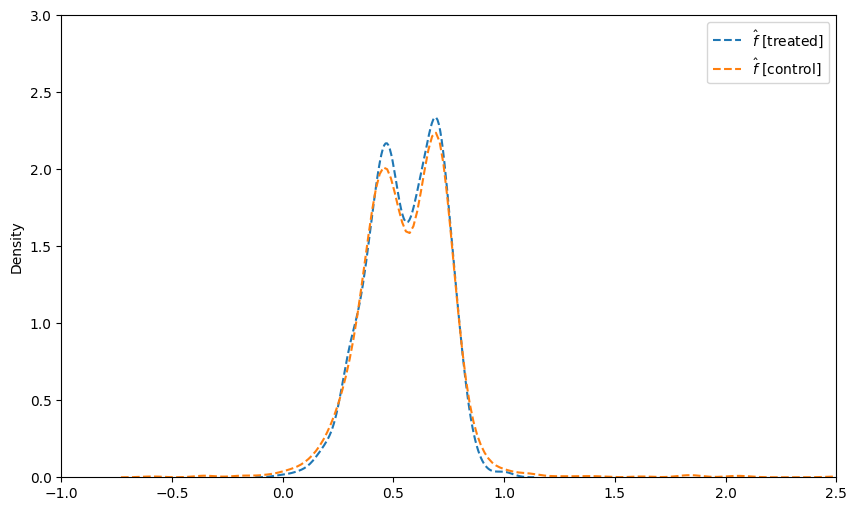

In [12]:
d1 = distance_matrix(X[control], X[treated])
fx_hat[control] = np.exp(-d1**2/(2*sigma**2))@C_hat

plt.figure(figsize=(10, 6))
plt.xlim(-1,2.5)
plt.ylim(0,3)
sns.kdeplot(fx_hat[treated],label=r'$\hat{f}$ [treated]',linestyle='--')
sns.kdeplot(fx_hat[control],label=r'$\hat{f}$ [control]',linestyle='--')
plt.legend(loc=1)
plt.show()

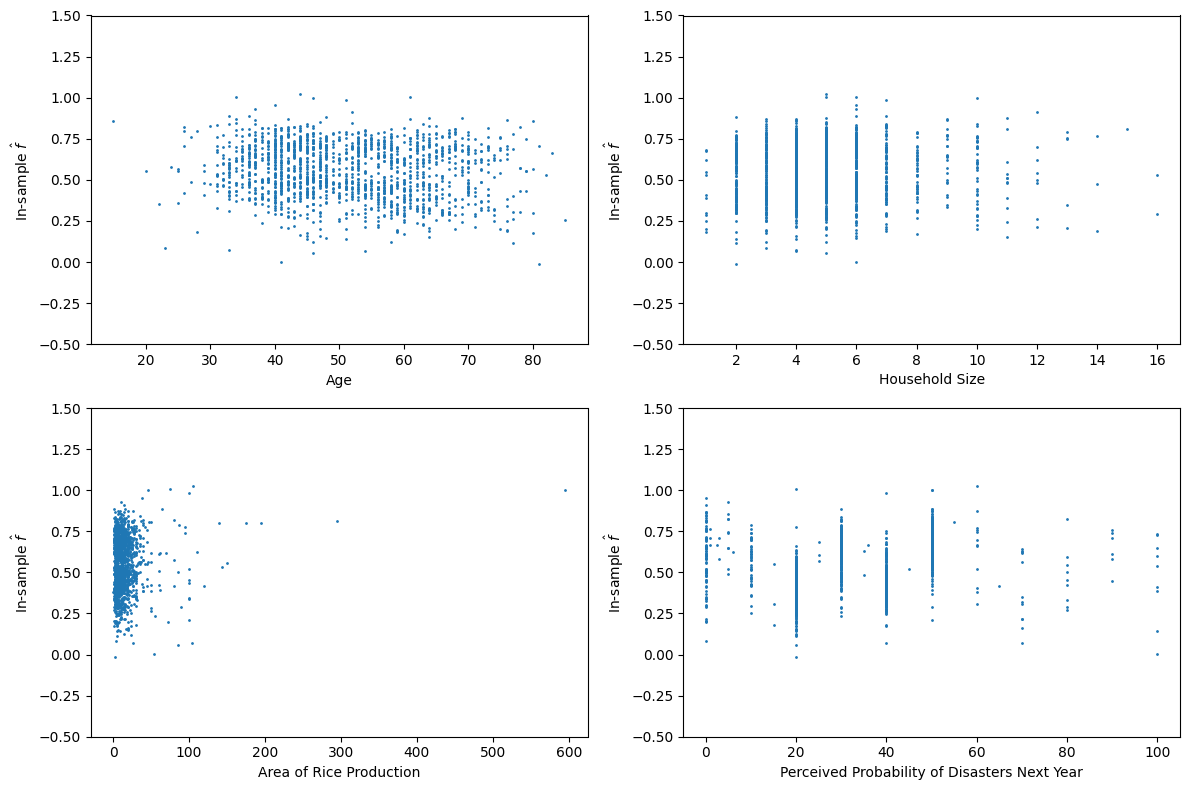

In [13]:
columns_to_plot = ['age','agpop','ricearea_2010','disaster_prob']
var_names = ['Age','Household Size','Area of Rice Production','Perceived Probability of Disasters Next Year']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(columns_to_plot):
    x_data = filtered_network_variables.iloc[treated, filtered_network_variables.columns.get_loc(col)]
    y_data = fx_hat[treated]

    not_nan_indices = (~np.isnan(x_data)) & (~np.isnan(y_data))
    x_data = x_data[not_nan_indices.values].reset_index(drop=True)
    y_data = y_data[not_nan_indices.values]

    sort_indices = np.argsort(x_data)
    x_data_sorted = x_data.iloc[sort_indices]

    axes[i].scatter(x_data, y_data, s=1)
    axes[i].set_xlabel(var_names[i])
    axes[i].set_ylabel(r'In-sample $\hat{f}$')
    axes[i].set_ylim(-0.5, 1.5)

plt.tight_layout()
plt.show()

Fit polynomial trend lines


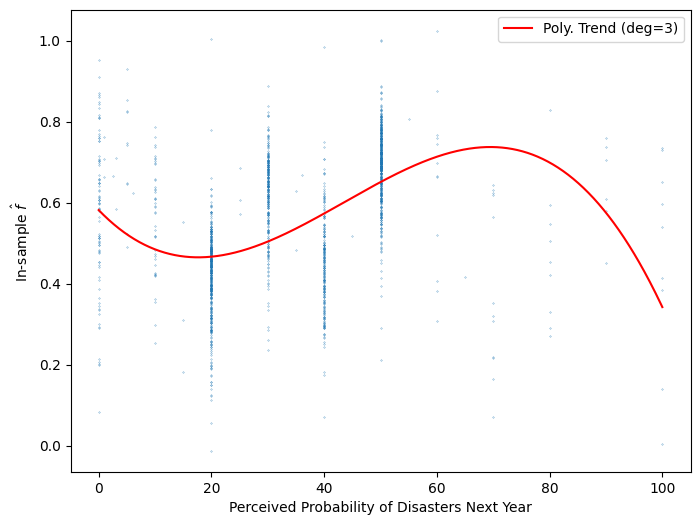

In [14]:
x_data = filtered_network_variables.iloc[treated, filtered_network_variables.columns.get_loc('disaster_prob')]
y_data = fx_hat[treated]

not_nan_indices = (~np.isnan(x_data)) & (~np.isnan(y_data))
x_data = x_data[not_nan_indices.values].reset_index(drop=True)
y_data = y_data[not_nan_indices.values]
x_grid = np.linspace(x_data.min(), x_data.max(), 1000)

deg1 = 3
coefficients1 = np.polyfit(x_data, y_data, deg1)
polynomial1 = np.poly1d(coefficients1)
trend_line_1 = polynomial1(x_grid)

sort_indices = np.argsort(x_grid)
trend_line_sorted1 = trend_line_1[sort_indices]
x_grid_sorted = x_grid[sort_indices]

plt.figure(figsize=(8, 6))
plt.scatter(x_data, y_data, s=0.05)
plt.xlabel('Perceived Probability of Disasters Next Year')
plt.ylabel(r'In-sample $\hat{f}$')
plt.plot(x_grid_sorted, trend_line_sorted1, color='red', label=f'Poly. Trend (deg={deg1})')
plt.legend()
plt.show()

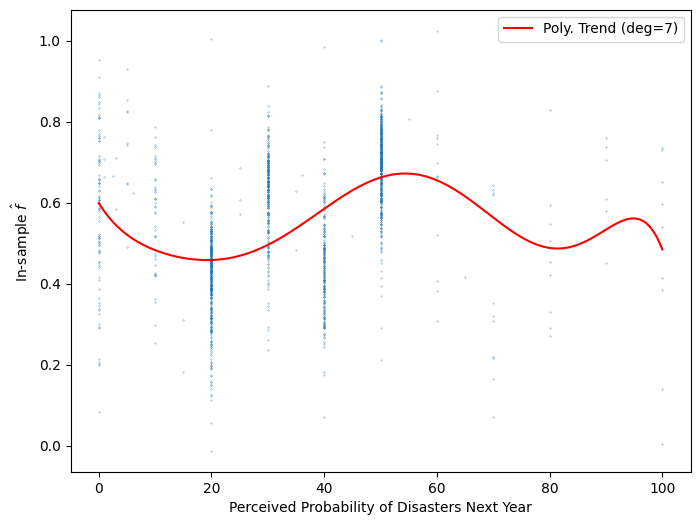

In [15]:
deg2 = 7
coefficients2 = np.polyfit(x_data, y_data, deg2)
polynomial2 = np.poly1d(coefficients2)
trend_line_2 = polynomial2(x_grid)
trend_line_sorted2 = trend_line_2[sort_indices]

plt.figure(figsize=(8, 6))
plt.scatter(x_data, y_data, s=0.05)
plt.xlabel('Perceived Probability of Disasters Next Year')
plt.ylabel(r'In-sample $\hat{f}$')
plt.plot(x_grid_sorted, trend_line_sorted2, color='red', label=f'Poly. Trend (deg={deg2})')
plt.legend()
plt.show()

##2. Outcome with Neighbors' Covariates ($GX$)

$$Y=\beta GY+\delta GZ + \gamma GX + f(X)\odot Z+\epsilon$$

In [16]:
iv2 = [np.linalg.matrix_power(filtered_G,(k+2))@T for k in range(q)]
iv2_2d = [arr.reshape(-1, 1) if arr.ndim == 1 else arr for arr in iv2]
iv3_list = [np.linalg.matrix_power(filtered_G,(k+2))@X for k in range(q)]
iv3 = np.hstack(iv3_list)

iv2 = np.hstack((iv2_2d + [iv3]))

gamma_hat2 = np.ones(X.shape[1])
beta_hat2 = 0.2
delta_hat2 = 0.5
GX = filtered_G@X
Y_pred = np.ones(V)*999

while True:
    Y_tilde = Y-beta_hat2*GY-delta_hat2*GT-GX@gamma_hat2
    C_hat2 = np.linalg.matrix_power(lam*np.diag(np.ones(int(sum(T))))+K,-1)@Y_tilde.iloc[treated]
    KC = K@C_hat2

    fx_hat = np.zeros(V)
    fx_hat[treated] = KC

    iv1 = np.array([np.linalg.matrix_power(filtered_G,(k+2))@np.multiply(fx_hat,T) for k in range(q)])
    ivs = np.column_stack((np.array(iv1).T,iv2))

    # Additional step to remove linear dependence in ivs
    rank_before = np.linalg.matrix_rank(ivs)
    Q, R, P = scipy.linalg.qr(ivs, mode='economic', pivoting=True)
    ivs_independent = ivs[:, P[:rank_before]]
    ivs = ivs_independent

    GY_hat = ivs@np.linalg.matrix_power(ivs.T@ivs,-1)@ivs.T@GY
    model = sm.OLS(Y - fx_hat, np.column_stack((GY_hat, GT, GX)))
    ivreg = model.fit()

    beta_hat2 = ivreg.params.iloc[0]
    delta_hat2 = ivreg.params.iloc[1]
    gamma_hat2 = ivreg.params.iloc[2:]

    Y_pred_new = fx_hat+ivreg.fittedvalues

    if np.linalg.norm(Y_pred_new - Y_pred)<0.00000001:
        print("Estimation converged")
        break
    Y_pred = Y_pred_new

Estimation converged


Examine the results

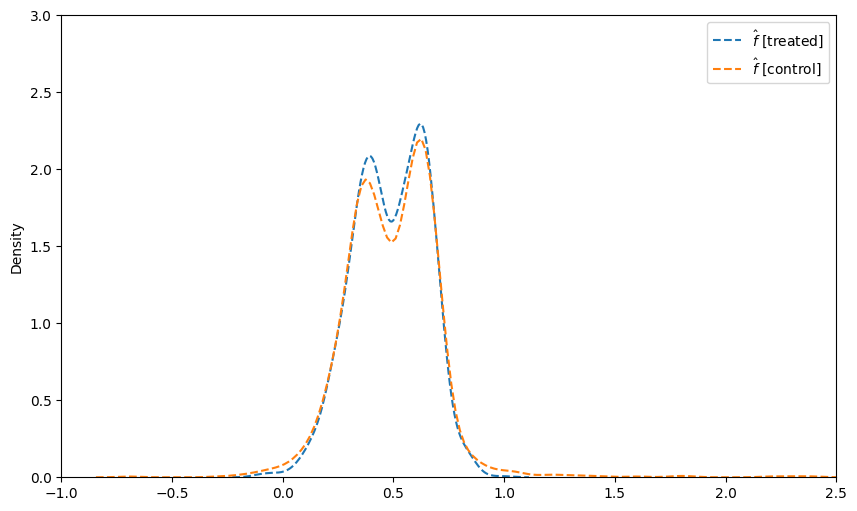

In [17]:
d1 = distance_matrix(X[control], X[treated])
fx_hat[control] = np.exp(-d1**2/(2*sigma**2))@C_hat2

plt.figure(figsize=(10, 6))
plt.xlim(-1,2.5)
plt.ylim(0,3)
sns.kdeplot(fx_hat[treated],label=r'$\hat{f}$ [treated]',linestyle='--')
sns.kdeplot(fx_hat[control],label=r'$\hat{f}$ [control]',linestyle='--')
plt.legend(loc=1)
plt.show()

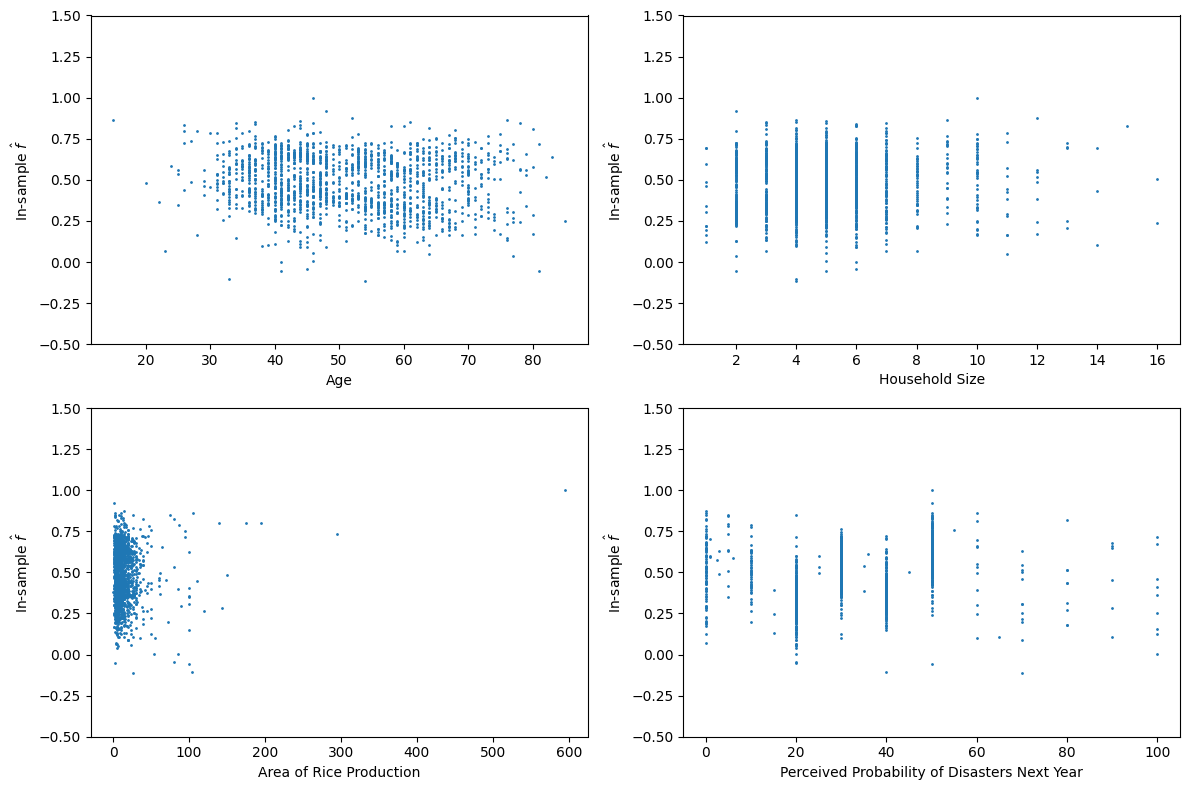

In [18]:
columns_to_plot = ['age','agpop','ricearea_2010','disaster_prob']
var_names = ['Age','Household Size','Area of Rice Production','Perceived Probability of Disasters Next Year']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(columns_to_plot):
    x_data = filtered_network_variables.iloc[treated, filtered_network_variables.columns.get_loc(col)]
    y_data = fx_hat[treated]

    not_nan_indices = (~np.isnan(x_data)) & (~np.isnan(y_data))
    x_data = x_data[not_nan_indices.values].reset_index(drop=True)
    y_data = y_data[not_nan_indices.values]

    sort_indices = np.argsort(x_data)
    x_data_sorted = x_data.iloc[sort_indices]

    axes[i].scatter(x_data, y_data, s=1)
    axes[i].set_xlabel(var_names[i])
    axes[i].set_ylabel(r'In-sample $\hat{f}$')
    axes[i].set_ylim(-0.5, 1.5)

plt.tight_layout()
plt.show()

# Counterfactual Experiments

Define individual influence as each individual's marginal contribution to sum of outcomes when no individual has received treatment.


## 1. Additional 10% Treatments

Case A: randomly assign 10%


In [19]:
# predict f(X) for all individuals
full_K = np.exp(-distance_matrix(X.reshape(V,p),X[treated].reshape(len(treated),p))**2/(2*sigma**2))
F_hat = full_K@C_hat
IBG_inv = np.linalg.matrix_power(np.diag(np.ones(V))-beta_hat*filtered_G,-1)

# Assign the additional treatments
np.random.seed(2025)
new_assign = np.random.choice(control, round(len(treated)/10), replace=False)
new_T_1a = T.copy()
new_T_1a.iloc[new_assign] = 1

# Calculate sum of outcomes
sum_a = sum(IBG_inv@(delta_hat*filtered_G@new_T_1a + np.multiply(F_hat,new_T_1a)))
print(sum_a/V)

0.2958730409055023


Case B: select 10% top contributors from the controlled individuals


In [20]:
new_T_1b = np.array(T.copy())
F = np.diag(F_hat)

v_T = np.ones(V) @ IBG_inv
v_T_G = v_T@filtered_G

# Calculate marginal contributions for all individuals
marginal_contributions = np.sum(IBG_inv@(delta_hat*filtered_G + F),axis=0)

marginal_contributions_control = marginal_contributions.copy()
marginal_contributions_control[treated] = -999

top_control_contributors = (np.argsort(marginal_contributions_control)[::-1])[0:round(0.1*len(treated))]

# Update new_T_1b with the selected treatments for control individuals
new_T_1b[top_control_contributors] = 1

sum_b = sum(IBG_inv@(delta_hat*filtered_G@new_T_1b + F@new_T_1b))
print(sum_b/V)

0.3142610435828393


In [21]:
print(f"Improvement over random assignment: {round(100*(sum_b-sum_a)/sum_a,2)}%")

Improvement over random assignment: 6.21%


## 2. Optimal Assignment with the Same Sample

Assign the same number of treatments but to the top contributors according to the individual influence criterion, and compare that against the status quo.


In [22]:
baseline = sum(IBG_inv@(delta_hat*filtered_G@T + np.multiply(F_hat,T)))

top_contributors = (np.argsort(marginal_contributions)[::-1])[0:int(np.sum(T))]
new_T_2 = np.zeros(V)
new_T_2[top_contributors] = 1

sum_2 = np.sum(IBG_inv@(delta_hat*filtered_G@new_T_2+F@new_T_2),axis=0)
print(f"Improvement over baseline: {round((sum_2-baseline)/baseline*100,2)}%")

Improvement over baseline: 29.98%


In [23]:
print(f"Increase in average insurance knowledge score of {round((sum_2-baseline)/V,2)}")

Increase in average insurance knowledge score of 0.08


# Diagnostics

- Remove all discrete variables

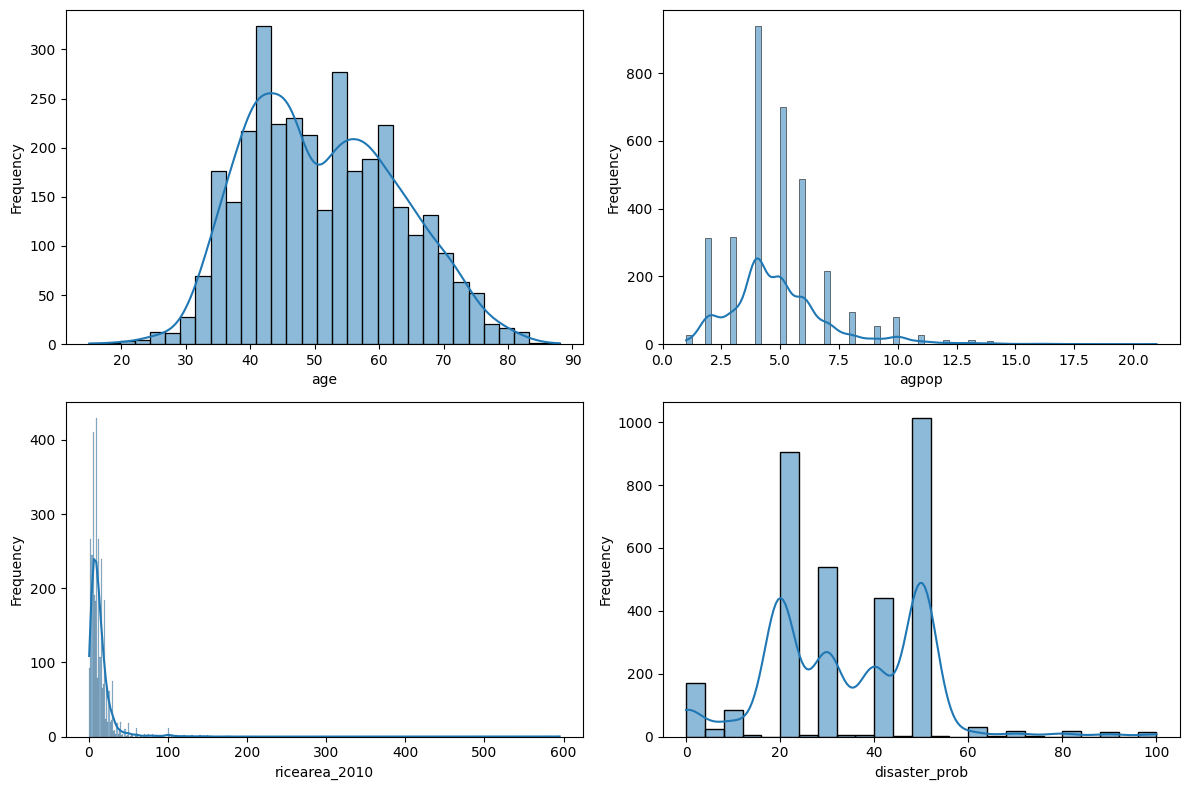

In [24]:
filtered_network_variables = network_variables[
    (network_variables['delay'] == 0) |
    ((network_variables['delay'] == 1) & (network_variables['info_none'] == 1))]

#################################################################
covariates = ['age','agpop','ricearea_2010','disaster_prob']
################################################################

filtered_network_variables = filtered_network_variables.dropna(subset=covariates+['understanding'])
filtered_indices = filtered_network_variables.index

ind = network_variables.index.isin(filtered_indices)
filtered_G = G[ind,:][:,ind]

columns_to_plot = ['age', 'agpop', 'ricearea_2010', 'disaster_prob']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()

for i, col in enumerate(columns_to_plot):
    sns.histplot(filtered_network_variables[col], kde=True, ax=axes[i])
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [25]:
T = filtered_network_variables['intensive']
Y = filtered_network_variables['understanding']
X = filtered_network_variables[covariates].values

V = len(filtered_G)
p = X.shape[1]
q = 5

treated = np.where(T==1)[0]
control = np.where(T==0)[0]
sigma = 20 # Kernel bandwidth
lam = 0.001 # kernel regularization term
beta_hat = 0.2 # initial beta
delta_hat = 0.5 # initial delta
parameters = [beta_hat,delta_hat]

K = np.exp(-distance_matrix(X[treated].reshape(int(sum(T)),p),X[treated].reshape(int(sum(T)),p))**2/(2*sigma**2))
Y_pred = np.ones(V)*999

# Run estimation
GY = filtered_G@Y
GT = filtered_G@T
iv2 = [np.linalg.matrix_power(filtered_G,(k+2))@T for k in range(q)]

while True:
    Y_tilde = Y-beta_hat*GY-delta_hat*GT
    C_hat = np.linalg.matrix_power(lam*np.diag(np.ones(int(sum(T))))+K,-1)@Y_tilde.iloc[treated]
    KC = K@C_hat

    fx_hat = np.zeros(V)
    fx_hat[treated] = KC

    iv1 = np.array([np.linalg.matrix_power(filtered_G,(k+2))@np.multiply(fx_hat,T) for k in range(q)])
    ivs = np.column_stack((np.array(iv1).T,np.array(iv2).T))

    ivreg = IV2SLS(
        dependent = Y-fx_hat, # dependent variable
        exog = GT, # exogenous regressors
        endog = GY, # endogenous regressors
        instruments = ivs, # instrumental variables
        weights = None).fit(cov_type="unadjusted")

    beta_hat = ivreg.params.iloc[0]
    delta_hat = ivreg.params.iloc[1]
    parameters = np.column_stack((parameters,ivreg.params))
    # iteration += 1
    Y_pred_new = fx_hat+beta_hat*GY+delta_hat*GT

    if np.linalg.norm(Y_pred_new - Y_pred)<0.00000001:
        print("Estimation converged")
        break
    Y_pred = Y_pred_new

beta_hat,delta_hat

Estimation converged


(np.float64(0.1236649034049097), np.float64(-0.0965766806794444))

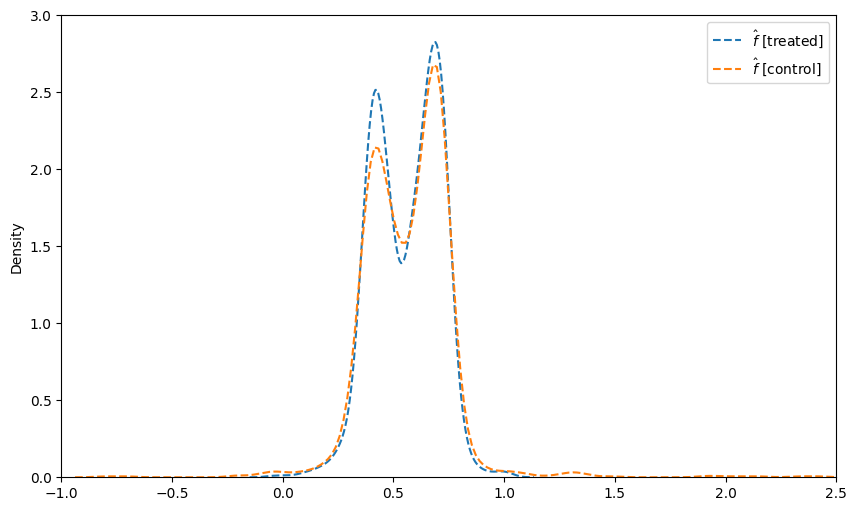

In [26]:
d2 = distance_matrix(X[control], X[treated])
fx_hat[control] = np.exp(-d2**2/(2*sigma**2))@C_hat

plt.figure(figsize=(10, 6))
plt.xlim(-1,2.5)
plt.ylim(0,3)
sns.kdeplot(fx_hat[treated],label=r'$\hat{f}$ [treated]',linestyle='--')
sns.kdeplot(fx_hat[control],label=r'$\hat{f}$ [control]',linestyle='--')
plt.legend(loc=1)
plt.show()

- Remove `disaster_prob`

In [27]:
filtered_network_variables = network_variables[
    (network_variables['delay'] == 0) |
    ((network_variables['delay'] == 1) & (network_variables['info_none'] == 1))]

#################################################################
covariates = ['age','agpop','ricearea_2010']
################################################################

filtered_network_variables = filtered_network_variables.dropna(subset=covariates+['understanding'])
filtered_indices = filtered_network_variables.index

ind = network_variables.index.isin(filtered_indices)
filtered_G = G[ind,:][:,ind]

T = filtered_network_variables['intensive']
Y = filtered_network_variables['understanding']
X = filtered_network_variables[covariates].values

V = len(filtered_G)
p = X.shape[1]
q = 5 # truncation degree of instruments

treated = np.where(T==1)[0]
control = np.where(T==0)[0]
sigma = 20 # Kernel bandwidth
lam = 0.001 # kernel regularization term
beta_hat = 0.2 # initial beta
delta_hat = 0.5 # initial delta
parameters = [beta_hat,delta_hat]

K = np.exp(-distance_matrix(X[treated].reshape(int(sum(T)),p),X[treated].reshape(int(sum(T)),p))**2/(2*sigma**2))
Y_pred = np.ones(V)*999

# Run estimation
GY = filtered_G@Y
GT = filtered_G@T
iv2 = [np.linalg.matrix_power(filtered_G,(k+2))@T for k in range(q)]

while True:
    Y_tilde = Y-beta_hat*GY-delta_hat*GT
    C_hat = np.linalg.matrix_power(lam*np.diag(np.ones(int(sum(T))))+K,-1)@Y_tilde.iloc[treated]
    KC = K@C_hat

    fx_hat = np.zeros(V)
    fx_hat[treated] = KC

    iv1 = np.array([np.linalg.matrix_power(filtered_G,(k+2))@np.multiply(fx_hat,T) for k in range(q)])
    ivs = np.column_stack((np.array(iv1).T,np.array(iv2).T))

    ivreg = IV2SLS(
        dependent = Y-fx_hat, # dependent variable
        exog = GT, # exogenous regressors
        endog = GY, # endogenous regressors
        instruments = ivs, # instrumental variables
        weights = None).fit(cov_type="unadjusted")

    beta_hat = ivreg.params.iloc[0]
    delta_hat = ivreg.params.iloc[1]
    parameters = np.column_stack((parameters,ivreg.params))
    # iteration += 1
    Y_pred_new = fx_hat+beta_hat*GY+delta_hat*GT

    if np.linalg.norm(Y_pred_new - Y_pred)<0.00000001:
        print("Estimation converged")
        break
    Y_pred = Y_pred_new

beta_hat,delta_hat

Estimation converged


(np.float64(0.08010343104147748), np.float64(0.008360658296498439))

In [ ]:
d3 = distance_matrix(X[control], X[treated])
fx_hat[control] = np.exp(-d3**2/(2*sigma**2))@C_hat

plt.figure(figsize=(10, 6))
plt.xlim(-1,2.5)
plt.ylim(0,10)
sns.kdeplot(fx_hat[treated],label=r'$\hat{f}$ [treated]',linestyle='--')
sns.kdeplot(fx_hat[control],label=r'$\hat{f}$ [control]',linestyle='--')
plt.legend(loc=1)
plt.show()

Check for non-linearity

In [ ]:
X = sm.add_constant(X)
model = sm.OLS(fx_hat, X).fit()

residuals = fx_hat - model.fittedvalues

# Create the residual plot
plt.figure(figsize=(8, 8))
plt.scatter(model.fittedvalues, residuals, color='black',s=0.5)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

Proportion of residuals between -0.2 and 0.2: 98.697%


/tmp/ipython-input-1046897743.py:17: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(model.fittedvalues, residuals, deg2)


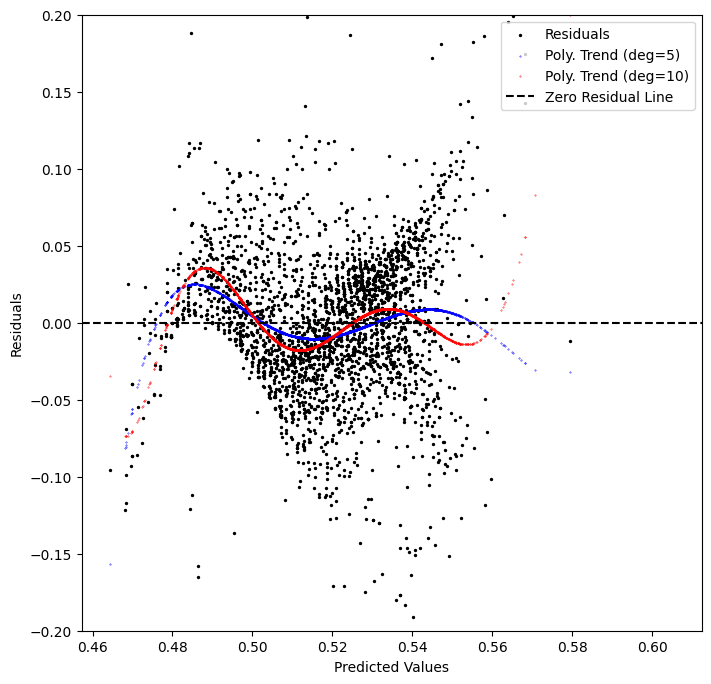

R^2 of the polynomial of degree 5: 0.031078740712761472
R^2 of the polynomial of degree 10: 0.04779596346559267


In [30]:
X = sm.add_constant(X)
model = sm.OLS(fx_hat, X).fit()

residuals = fx_hat - model.fittedvalues

# Zoom into the point cloud
count_within_range = np.sum((residuals >= -0.2) & (residuals <= 0.2))
print(f"Proportion of residuals between -0.2 and 0.2: {round(count_within_range / len(residuals),5)*100}%")

# Fit a polynomial trend line to the residuals
deg1 = 5  # degree of the polynomial
coefficients = np.polyfit(model.fittedvalues, residuals, deg1)
polynomial = np.poly1d(coefficients)
trend_line5 = polynomial(model.fittedvalues)

deg2 = 10  # degree of the polynomial
coefficients = np.polyfit(model.fittedvalues, residuals, deg2)
polynomial = np.poly1d(coefficients)
trend_line10 = polynomial(model.fittedvalues)

# Create the residual plot with the trend line
plt.figure(figsize=(8, 8))
plt.scatter(model.fittedvalues, residuals, color='black', label="Residuals",s=2)
plt.scatter(model.fittedvalues, trend_line5, color='b', label=f"Poly. Trend (deg={deg1})",s=0.1)
plt.scatter(model.fittedvalues, trend_line10, color='r', label=f"Poly. Trend (deg={deg2})",s=0.1)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.ylim(-0.2,0.2)
plt.axhline(y=0, color='black', linestyle='--', label="Zero Residual Line")  # Add a horizontal line at y=0
plt.legend(loc=1)
plt.show()

# Assess the polynomial fit
tss = np.sum((residuals - np.mean(residuals))**2)
rss5 = np.sum((residuals - trend_line5)**2)
rss10 = np.sum((residuals - trend_line10)**2)
rsq5 = (tss - rss5) / tss
rsq10 = (tss - rss10) / tss

print(f"R^2 of the polynomial of degree {deg1}: {rsq5}")
print(f"R^2 of the polynomial of degree {deg2}: {rsq10}")